In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
import re
import string
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Input,LSTM,Embedding,Dense,Dropout,Activation
from keras.models import Model,Sequential
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Data

In [2]:
train = pd.read_csv(r"C:\Users\aayus\Desktop\Kaggle\real-or-fake-tweets\train.csv")
test = pd.read_csv(r"C:\Users\aayus\Desktop\Kaggle\real-or-fake-tweets\test.csv")
sample_submission = pd.read_csv(r"C:\Users\aayus\Desktop\Kaggle\real-or-fake-tweets\sample_submission.csv")

In [3]:
train = train.fillna("")

In [4]:
train['text2clean'] = train[['keyword','location','text']].apply(lambda x: ' '.join(x), axis=1)

In [5]:
test = test.fillna('')

In [6]:
test['text2clean'] = test[['keyword','location','text']].apply(lambda x: ' '.join(x), axis=1)

#### Cleaning text

In [7]:
stopwords = stopwords.union(set(['http','https','com','co','this','like','amp','via','#']))

In [8]:
def cleaning_text(text):
    text = text.lower()
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " ", text)
    text = re.sub(r"\=", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r":", " ", text)
    text = re.sub('\[.*?\]',' ',text)
    text = re.sub('(%s)' % re.escape(string.punctuation),'',text)
    text = re.sub('\w*\d\w*',' ',text)
    text = re.sub('#',' ',text)
    text = re.sub('@',' ',text)
    text = re.sub('\?',' ',text)
    text = re.sub('\_',' ',text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    x = text.split()
    text = [i for i in x if i not in stopwords]
    text = " ".join(text)
    text = re.sub('thi','',text)
    text = re.sub('co','',text)
    return text

In [9]:
train['cleantext'] = train.text2clean.apply(lambda x: cleaning_text(x))

In [10]:
test['cleantext'] = test.text2clean.apply(lambda x: cleaning_text(x))

### GloVE

In [11]:
glove_file = "glove.twitter.27B.200d.txt"

In [12]:
word2vec_file = "glove2w2v.word2vec"

In [13]:
glove2word2vec(glove_input_file=glove_file,word2vec_output_file=word2vec_file)

(1193514, 200)

In [14]:
w2v_model = KeyedVectors.load_word2vec_format(word2vec_file,binary=False)

In [15]:
words = list(w2v_model.wv.vocab)
len(words)

1193514

In [16]:
w2v_model.wv.most_similar(cleaning_text("fire"))

[('burning', 0.6376731991767883),
 ('near', 0.6279622912406921),
 ('the', 0.6254713535308838),
 ('fires', 0.6131499409675598),
 ('dead', 0.6122781038284302),
 ('burn', 0.60842365026474),
 ('after', 0.5980007648468018),
 ('there', 0.5952222943305969),
 ('now', 0.5946906208992004),
 ('out', 0.5923745632171631)]

In [17]:
w2v_model.wv.syn0.shape

(1193514, 200)

In [18]:
w2v_model.wv.syn0

array([[ 3.1553e-01,  5.3765e-01,  1.0177e-01, ..., -4.5664e-01,
        -4.6540e-01,  5.2066e-01],
       [ 3.5132e-01,  5.6084e-04, -2.1488e-01, ...,  3.6684e-02,
        -3.7206e-02,  8.5384e-01],
       [ 8.0767e-01,  4.9786e-01,  8.2696e-02, ..., -7.3302e-02,
        -4.7785e-01,  6.7059e-01],
       ...,
       [ 4.6298e-01,  1.0477e-01,  2.3461e-01, ..., -4.2007e-01,
        -3.2021e-01, -5.3523e-01],
       [ 5.9501e-01, -2.1580e-01,  2.9049e-01, ...,  2.2362e-01,
         1.2880e-01, -3.8757e-02],
       [-5.9487e-01, -1.9176e-01,  3.7470e-01, ..., -1.4474e-01,
        -1.9884e-01, -9.2338e-01]], dtype=float32)

### Model Specification

In [19]:
glove_weight = w2v_model.wv.syn0

In [20]:
vocab_size = w2v_model.wv.syn0.shape[0]

In [21]:
embedding_dim = 200

In [22]:
Embedding_layer = Embedding(input_dim=vocab_size,output_dim=embedding_dim,weights=[glove_weight])

In [23]:
model = Sequential()

In [24]:
model.add(Embedding_layer)

In [25]:
model.add(LSTM(embedding_dim,activation='relu'))

In [26]:
model.add(Dense(1,activation='sigmoid'))

In [27]:
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         238702800 
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 239,023,801
Trainable params: 239,023,801
Non-trainable params: 0
_________________________________________________________________


### Training

In [29]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train.cleantext)
seq = tokenizer.texts_to_sequences(train.cleantext)
data = pad_sequences(sequences=seq)

In [30]:
classifier = model.fit(data,train.target,validation_split=0.2,epochs=50)

Train on 6090 samples, validate on 1523 samples
Epoch 1/50
6090/6090 [==============================] - 1083s 178ms/step - loss: 0.1995 - accuracy: 0.6874 - val_loss: 0.1916 - val_accuracy: 0.7131
Epoch 2/50
6090/6090 [==============================] - 897s 147ms/step - loss: 0.1143 - accuracy: 0.8488 - val_loss: 0.1808 - val_accuracy: 0.7400
Epoch 3/50
6090/6090 [==============================] - 695s 114ms/step - loss: 0.0679 - accuracy: 0.9164 - val_loss: 0.1876 - val_accuracy: 0.7301
Epoch 4/50
6090/6090 [==============================] - 693s 114ms/step - loss: 0.0390 - accuracy: 0.9542 - val_loss: 0.2166 - val_accuracy: 0.7045
Epoch 5/50
6090/6090 [==============================] - 7753s 1s/step - loss: 0.0248 - accuracy: 0.9703 - val_loss: 0.2343 - val_accuracy: 0.7006
Epoch 6/50
6090/6090 [==============================] - 739s 121ms/step - loss: 0.0185 - accuracy: 0.9788 - val_loss: 0.2277 - val_accuracy: 0.7190
Epoch 7/50
6090/6090 [==============================] - 734s 120m

In [31]:
import pickle
filename="NN_Glove"
pickle.dump(classifier, open(filename, 'wb'))

### Loss Function

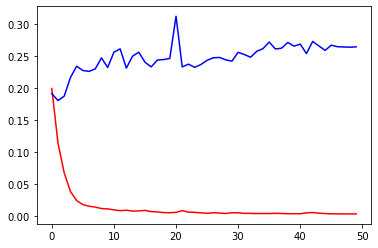

In [32]:
plt.plot(classifier.history['loss'],c="r")
plt.plot(classifier.history['val_loss'],c="b")
plt.show()

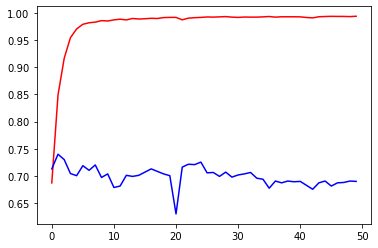

In [33]:
plt.plot(classifier.history['accuracy'],c="r")
plt.plot(classifier.history['val_accuracy'],c="b")
plt.show()

### Predictions

In [120]:
tokenizer2 = Tokenizer(num_words=vocab_size)
tokenizer2.fit_on_texts(test.cleantext)
seq2 = tokenizer2.texts_to_sequences(test.cleantext)
test_data = pad_sequences(sequences=seq2)

In [122]:
preds = model.predict(test_data)

In [124]:
sample_submission.target = preds
sample_submission.target = [0 if sample_submission.target[i] < 0.5 else 1 for i in range(len(sample_submission))]

In [126]:
sample_submission.to_csv("gloveNN.csv",index=False)